# Shorthand to text transformer architecture

## Setup and Imports

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

## Compile smaller data selection (random)

In [197]:
# import os
# import shutil
# import random
# from pathlib import Path

# def create_mini_dataset(source_dir='data', target_dir='data-Mini', percentage=0.01):
#     # Create target directory if it doesn't exist
#     Path(target_dir).mkdir(parents=True, exist_ok=True)
    
#     # Get all image files
#     image_files = [f for f in os.listdir(source_dir) 
#                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
#     # Calculate number of files to select
#     num_files = len(image_files)
#     num_files_to_select = max(1, int(num_files * percentage))
    
#     # Randomly select files
#     selected_files = random.sample(image_files, num_files_to_select)
    
#     # Copy selected files to new directory
#     for file_name in selected_files:
#         source_path = os.path.join(source_dir, file_name)
#         target_path = os.path.join(target_dir, file_name)
#         shutil.copy2(source_path, target_path)
    
#     print(f"Original dataset size: {num_files} images")
#     print(f"Mini dataset size: {num_files_to_select} images")
#     print(f"Mini dataset created in: {target_dir}")

# # Create the mini dataset
# # Example with different parameters
# create_mini_dataset(
#     source_dir='data',
#     target_dir='data_mini',
#     percentage=0.01  # 5% instead of 1%
# )

## Data Loading

In [198]:
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

class KeepAspectRatioPad(object):
    """
    Resize the image to fit within the target size while preserving aspect ratio,
    then pad the result to the target size.
    """
    def __init__(self, target_size=(64, 64), fill=255):
        self.target_size = target_size
        self.fill = fill  # Color to use for padding
        
    def __call__(self, img):
        # Get original dimensions
        w_orig, h_orig = img.size
        w_target, h_target = self.target_size
        
        # Determine scale factor to maintain aspect ratio
        aspect_ratio = w_orig / h_orig
        
        if aspect_ratio > 1:
            # Image is wider than tall
            new_w = min(w_orig, w_target)
            new_h = int(new_w / aspect_ratio)
        else:
            # Image is taller than wide (or square)
            new_h = min(h_orig, h_target)
            new_w = int(new_h * aspect_ratio)
            
        # Resize maintaining aspect ratio
        resized_img = img.resize((new_w, new_h), Image.LANCZOS)
        
        # Create new image with target size and paste resized image
        new_img = Image.new(img.mode, self.target_size, self.fill)
        
        # Calculate position for pasting (center)
        paste_x = (w_target - new_w) // 2
        paste_y = (h_target - new_h) // 2
        
        # Paste resized image onto padded background
        new_img.paste(resized_img, (paste_x, paste_y))
        
        return new_img
    
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to single channel if not already
    KeepAspectRatioPad(target_size=(64, 64), fill=0),  # Preserve aspect ratio and pad
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # For grayscale
])


In [199]:
import os
import pickle

def load_phonetic_dict(pickle_file='phonetic_cache.pkl', text_file='phonetics_output.txt'):
    """Load phonetic dictionary from either pickle or text file"""
    # Try loading from pickle first (faster)
    if os.path.exists(pickle_file):
        try:
            with open(pickle_file, 'rb') as f:
                phonetic_dict = pickle.load(f)
            print(f"Loaded {len(phonetic_dict)} words from phonetic cache")
            return phonetic_dict
        except Exception as e:
            print(f"Error loading pickle file: {e}")
    
    # Fall back to text file
    if os.path.exists(text_file):
        try:
            phonetic_dict = {}
            with open(text_file, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                
            # Skip header lines
            for line in lines[2:]:  # Skip "WORD PHONETICS" and the dashes
                if '\t' in line:
                    word, phonetics = line.strip().split('\t')
                    phonetic_dict[word] = list(phonetics)
            
            print(f"Loaded {len(phonetic_dict)} words from text file")
            return phonetic_dict
        except Exception as e:
            print(f"Error loading text file: {e}")
    
    print("No phonetic dictionary found, returning empty dictionary")
    return {}

# Load the phonetic dictionary
phonetic_dict = load_phonetic_dict()

Loaded 15279 words from phonetic cache


In [200]:
class ShorthandDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(),
            KeepAspectRatioPad(target_size=(64, 64), fill=255),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])
        self.image_files = [f for f in os.listdir(data_dir) 
                           if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.labels = [os.path.splitext(f)[0] for f in self.image_files]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.labels[idx]

In [201]:
# Define transforms
transform = transforms.Compose([
            transforms.Grayscale(),
            KeepAspectRatioPad(target_size=(64, 64), fill=255),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

# Now create the dataset
dataset = ShorthandDataset('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

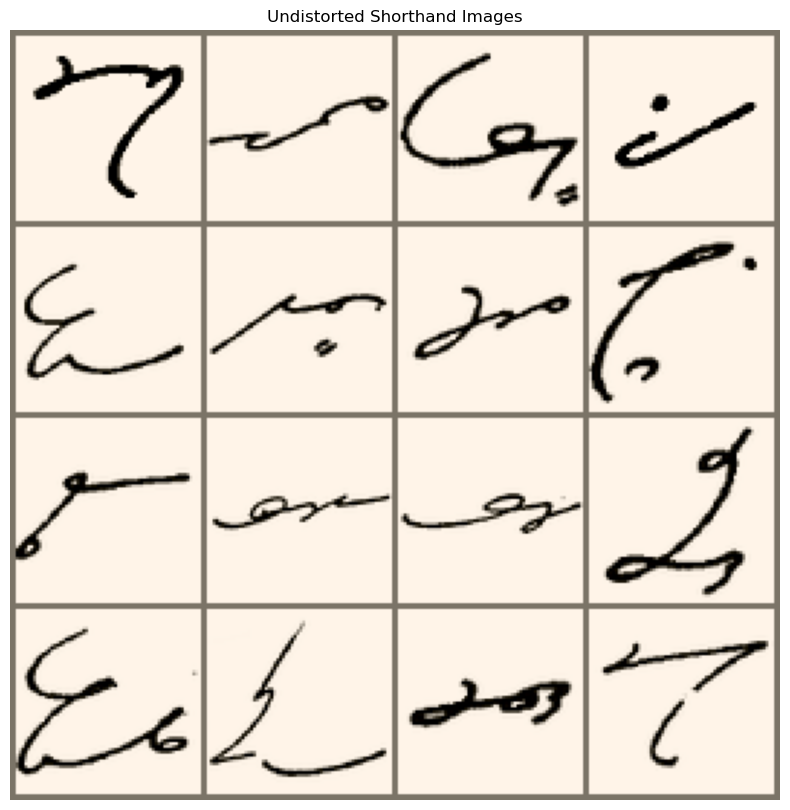

Batch shape: torch.Size([32, 1, 64, 64])
Sample labels: ('scoop', 'noteworthy', 'blanch', 'hot', 'perpetual')


In [202]:
# Create a function to visualize the results
def visualize_undistorted_batch(dataloader):
    """
    Visualize a batch of images to verify they're not stretched
    """
    images, labels = next(iter(dataloader))
    
    # Create a grid of images
    grid = torchvision.utils.make_grid(images[:16], nrow=4)
    
    # Unnormalize
    if grid.shape[0] == 1:  # Grayscale
        mean = torch.tensor([0.485]).view(1, 1, 1)
        std = torch.tensor([0.229]).view(1, 1, 1)
    else:  # RGB
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    grid = grid * std + mean
    grid = torch.clamp(grid, 0, 1)
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Undistorted Shorthand Images")
    plt.show()
    
    print(f"Batch shape: {images.shape}")
    print(f"Sample labels: {labels[:5]}")
visualize_undistorted_batch(dataloader)

## Attention Layer

In [203]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # x shape: [batch, seq_len, hidden]
        attention_scores = self.attention(x)  # [batch, seq_len, 1]
        attention_weights = F.softmax(attention_scores, dim=1)
        context = torch.sum(x * attention_weights, dim=1)  # [batch, hidden]
        return context, attention_weights

In [204]:
import math
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=8, dropout_rate=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0, "Hidden size must be divisible by number of heads"
        
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        # Linear projections for Query, Key, Value
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        
        # Output projection
        self.output = nn.Linear(hidden_size, hidden_size)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len, hidden_size]
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Linear projections and reshape for multi-head attention
        # Shape: [batch_size, seq_len, hidden_size] -> [batch_size, seq_len, num_heads, head_dim]
        q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Transpose for the attention calculation
        # Shape: [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Calculate attention scores: [batch_size, num_heads, seq_len, seq_len]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention weights to values
        # Shape: [batch_size, num_heads, seq_len, head_dim]
        context = torch.matmul(attention_weights, v)
        
        # Transpose and reshape back to original dimensions
        # Shape: [batch_size, seq_len, hidden_size]
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)
        
        # Final linear projection
        output = self.output(context)
        
        return output, attention_weights

## Main Model

In [205]:
class ShorthandModel(nn.Module):
    def __init__(self, num_phonetic_units, phonetic_units, dropout_rate=0.3):
        super(ShorthandModel, self).__init__()
        self.phonetic_units = phonetic_units
        self.blank_idx = num_phonetic_units
        self.lstm_hidden_size = 512

        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(dropout_rate)

        # Check size after convolutions
        self.calc_conv_output_size()

        # Dense layer to prepare for LSTM
        self.fc_prep = nn.Linear(self.conv_output_size, 512)
        self.dropout_fc = nn.Dropout(dropout_rate)

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=512,
            hidden_size=512,
            num_layers=3,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if dropout_rate > 0 else 0
        )
        
        # Replace simple attention with multi-head attention
        self.multi_head_attention = MultiHeadAttention(
            hidden_size=self.lstm_hidden_size * 2,  # *2 for bidirectional
            num_heads=8,
            dropout_rate=dropout_rate
        )
        
        # Add layer normalization
        self.layer_norm1 = nn.LayerNorm(self.lstm_hidden_size * 2)
        self.layer_norm2 = nn.LayerNorm(self.lstm_hidden_size * 2)
        
        # Feed-forward network after attention
        self.feed_forward = nn.Sequential(
            nn.Linear(self.lstm_hidden_size * 2, self.lstm_hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(self.lstm_hidden_size * 4, self.lstm_hidden_size * 2)
        )

        # Output layer - num_phonetic_units + 1 for blank token (CTC requirement)
        self.output = nn.Linear(self.lstm_hidden_size * 2, num_phonetic_units + 1)

        # Add training-specific attributes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.CTCLoss(blank=num_phonetic_units)  # blank token added

        self._initialize_weights()

        # Add dictionary to map indices to phonetic units
        self.idx_to_phonetic = {i: unit for i, unit in enumerate(phonetic_units)}
        self.idx_to_phonetic[num_phonetic_units] = '<blank>'  # Add blank token

    def calc_conv_output_size(self):
        # Helper function to calculate conv output size
        # 1=Batch size, 1:Num of color channels, (64,64):Image size
        x = torch.randn(1, 1, 64, 64)
        # Apply convolutions with pooling
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        # Get dimensions after convolutions
        self.conv_output_shape = x.shape
        _, C, H, W = x.shape
        # Total flattened size
        self.conv_output_size = C * H * W
        # Print sizes for debugging
        print(f"Conv output shape: {x.shape}")
        print(f"Conv output size: {self.conv_output_size}")
        
    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with regularization
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)
        
        # Apply the FC layer preparation
        _, C, H, W = x.size()
        
        # For debugging
        if W == 0 or H == 0:
            print(f"Error: Invalid dimensions: C={C}, H={H}, W={W}")
            return torch.zeros(batch_size, 1, len(self.phonetic_units) + 1, device=self.device)
        
        x = x.permute(0, 3, 1, 2)  # [batch, width, channels, height]
        batch_size, seq_len, channels, height = x.size()
        
        # Reshape with safety check
        try:
            x = x.reshape(batch_size * seq_len, channels * height)
        except RuntimeError as e:
            print(f"Reshape error: {e}")
            print(f"Sizes: batch={batch_size}, seq={seq_len}, C={channels}, H={height}")
            # Return zeros as fallback to avoid crash
            return torch.zeros(batch_size, seq_len, len(self.phonetic_units) + 1, device=self.device)
        
        # Dynamically recreate fc_prep if needed
        required_input_size = channels * height
        if not hasattr(self, 'actual_input_size') or self.actual_input_size != required_input_size:
            self.actual_input_size = required_input_size
            self.fc_prep = nn.Linear(required_input_size, 512).to(self.device)
            print(f"Recreated fc_prep layer with input size: {required_input_size}")
        
        # Apply FC with NaN check
        x = self.fc_prep(x)
        x = F.relu(x)
        if torch.isnan(x).any():
            print("Warning: NaN values after FC layer")
            x = torch.nan_to_num(x, nan=0.0)
        
        x = self.dropout_fc(x)
        x = x.view(batch_size, seq_len, 512)
        
        # LSTM with safety
        try:
            lstm_out, _ = self.lstm(x)
        except RuntimeError as e:
            print(f"LSTM error: {e}")
            return torch.zeros(batch_size, seq_len, len(self.phonetic_units) + 1, device=self.device)
        
        # Apply multi-head attention with residual connection and layer normalization
        # Residual connection 1
        attn_out, attention_weights = self.multi_head_attention(lstm_out)
        attn_out = self.dropout_fc(attn_out)
        lstm_out = self.layer_norm1(lstm_out + attn_out)  # Add & Norm
        
        # Feed-forward network with residual connection
        ff_out = self.feed_forward(lstm_out)
        ff_out = self.dropout_fc(ff_out)
        lstm_out = self.layer_norm2(lstm_out + ff_out)  # Add & Norm
        
        # Apply temperature scaling to outputs to prevent overconfidence
        temperature = 4.0  # Adjust this value to control prediction confidence

        # Create a bias correction vector to discourage 'æ'
        bias_correction = torch.zeros(len(self.phonetic_units) + 1, device=self.device)
        if 'æ' in self.phonetic_units:
            æ_idx = self.phonetic_units.index('æ')
            bias_correction[æ_idx] = -1.0  # Negative bias for 'æ'

        output = self.output(lstm_out) / temperature
        output = output + bias_correction.unsqueeze(0).unsqueeze(0)
        
        # Return log_probs directly to avoid NaN later
        return F.log_softmax(output, dim=2)
    
    def decode_ctc(self, log_probs):
        """
        Improved CTC decoder that properly handles blank tokens and encourages longer sequences
        """
        batch_size, seq_len, num_classes = log_probs.shape
        
        # Convert to probabilities
        probs = torch.exp(log_probs)
        
        # Process each batch
        results = []
        for b in range(batch_size):
            # Strategy 1: Use beam search (simplified version)
            beam_size = 3
            beams = [{"sequence": [], "score": 0.0}]
            
            for t in range(seq_len):
                new_beams = []
                for beam in beams:
                    # Get top-k predictions at this time step
                    step_probs = probs[b, t]
                    top_k_probs, top_k_indices = torch.topk(step_probs, k=beam_size)
                    
                    for prob, idx in zip(top_k_probs.cpu().numpy(), top_k_indices.cpu().numpy()):
                        # Skip if it's a repeat of the last token (unless it's a different token)
                        if len(beam["sequence"]) > 0 and idx == beam["sequence"][-1] and idx != self.blank_idx:
                            continue
                        
                        # Create new beam with this token
                        new_seq = beam["sequence"] + ([idx] if idx != self.blank_idx else [])
                        new_score = beam["score"] + np.log(prob)
                        new_beams.append({"sequence": new_seq, "score": new_score})
                
                # Keep only the top beams
                new_beams.sort(key=lambda x: x["score"], reverse=True)
                beams = new_beams[:beam_size]
            
            # Get the best sequence
            best_sequence = beams[0]["sequence"] if beams else []
            
            # Fallback if sequence is empty
            if not best_sequence:
                # Get top-2 most likely non-blank phonetic units overall
                avg_probs = probs[b].mean(dim=0).cpu().numpy()
                avg_probs[self.blank_idx] = 0  # Exclude blank
                top_indices = np.argsort(avg_probs)[-2:][::-1]  # Top 2 indices
                
                # Create a minimal sequence with these two units
                phonetic_seq = []
                for idx in top_indices:
                    if idx < len(self.phonetic_units):
                        phonetic_seq.append(self.phonetic_units[idx])
                
            else:
                # Convert indices to phonetic units
                phonetic_seq = [self.phonetic_units[idx] if idx < len(self.phonetic_units) else '?' 
                            for idx in best_sequence]
            
            results.append(''.join(phonetic_seq))
        
        return results
    
    def sample_sequence(self, log_probs, temperature=2.0):
        """Sample sequence using categorical distribution instead of greedy decoding"""
        batch_size, seq_len, num_classes = log_probs.shape
        
        # Convert log_probs to probabilities
        probs = torch.exp(log_probs / temperature)  # Add temperature scaling
        
        # Sample from categorical distribution
        sampled_indices = torch.zeros((batch_size, seq_len), dtype=torch.long, device=self.device)
        for b in range(batch_size):
            for t in range(seq_len):
                # Sample from categorical distribution
                distribution = torch.distributions.Categorical(probs[b, t])
                sampled_indices[b, t] = distribution.sample()
        
        # Convert sampled indices to phonetic sequences
        results = []
        for b in range(batch_size):
            # Extract indices
            indices = sampled_indices[b].cpu().numpy()
            
            # Perform CTC collapsing: remove duplicates and blanks
            collapsed = []
            for i, idx in enumerate(indices):
                # Skip blank tokens
                if idx == self.blank_idx:
                    continue
                    
                # Add token if it's not a duplicate of the previous non-blank token
                if len(collapsed) == 0 or idx != collapsed[-1]:
                    collapsed.append(idx)
            
            # Convert indices to phonetic units
            if not collapsed:
                # Get default phonetic unit (something other than æ)
                avg_probs = probs[b].mean(dim=0).cpu().numpy()
                # Create a copy and set blank token and æ probability to 0
                modified_probs = avg_probs.copy()
                modified_probs[self.blank_idx] = 0
                if 'æ' in self.phonetic_units:
                    æ_idx = self.phonetic_units.index('æ')
                    modified_probs[æ_idx] = 0
                # Get the most likely non-blank, non-æ token
                best_token = np.argmax(modified_probs)
                phonetic_seq = [self.phonetic_units[best_token]] if best_token < len(self.phonetic_units) else ['ə']
            else:
                phonetic_seq = [self.phonetic_units[idx] if idx < len(self.phonetic_units) else '?' 
                            for idx in collapsed]
            
            results.append(''.join(phonetic_seq))
        
        return results, sampled_indices, probs
    
    def _initialize_weights(self):
        """Initialize model weights to prevent exploding gradients"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # More aggressive regularization for output layer
                nn.init.xavier_normal_(m.weight, gain=0.5)  # Reduced gain
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
    
    def phonetics_to_tensor(self, phonetic_sequences):
        """Convert phonetic sequences to tensor of indices"""
        # Create mapping of phonetic unit to index
        unit_to_idx = {unit: idx for idx, unit in enumerate(self.phonetic_units)}
        
        # Convert sequences to index tensors
        tensors = []
        for seq in phonetic_sequences:
            indices = [unit_to_idx.get(unit, 0) for unit in seq]  # Default to 0 if not found
            tensors.append(torch.tensor(indices, dtype=torch.long))
        
        # Get sequence lengths for CTC
        seq_lengths = [len(t) for t in tensors]
        
        # Pad sequences to same length
        max_len = max(seq_lengths)
        padded = torch.full((len(tensors), max_len), len(self.phonetic_units), dtype=torch.long)  # pad with blank token
        for i, t in enumerate(tensors):
            padded[i, :len(t)] = t
            
        return padded.to(self.device), torch.tensor(seq_lengths, dtype=torch.long).to(self.device)

#     def train_batch(self, images, phonetic_sequences, batch_num):
#         """Train on a batch of images"""
#         self.train()
#         self.optimizer.zero_grad()
        
#         # Prepare data
#         images = images.to(self.device)  # [batch_size, 1, 64, 64]
#         targets = self.phonetics_to_tensor(phonetic_sequences)
        
#         # Forward pass
#         log_probs = F.log_softmax(self(images), dim=-1)
        
#         # Calculate loss
#         batch_size = images.size(0)
#         input_lengths = torch.full((batch_size,), log_probs.size(1), dtype=torch.long)
#         target_lengths = torch.tensor([len(t) for t in phonetic_sequences], dtype=torch.long)
        
#         loss = self.criterion(log_probs, targets, input_lengths, target_lengths)
        
#         # Backward pass and optimize
#         loss.backward()
#         self.optimizer.step()
        
#         self.batchesTrained += 1
#         return loss.item()

#     def infer_batch(self, images):
#         """Recognize phonetic sequences in batch of images"""
#         self.eval()
#         with torch.no_grad():
#             # Prepare data
#             images = images.to(self.device)
            
#             # Forward pass
#             output = self(images)
#             log_probs = F.log_softmax(output, dim=-1)
            
#             # Decode
#             decoded_sequences = self.decode_greedy(log_probs)
            
#         return decoded_sequences


# # def decodeGreggShorthand(self, probabilities, input_lengths):
# #     """Specialized decoder for Gregg shorthand"""
# #     # First pass: Get most likely phonetic units
# #     phonetic_transcription = self.decodeGreedy(probabilities, input_lengths)
    
# #     # Second pass: Apply phonetic-to-text rules
# #     text_results = []
# #     for transcript in phonetic_transcription:
# #         # Apply contextual rules to convert phonetic to text
# #         # Handle brief forms (common words with special symbols)
# #         # Resolve ambiguities using language model
# #         text = self.phoneticToText(transcript)
# #         text_results.append(text)
    
# #     return text_results

## Translate words to phonetics

In [206]:
import pickle
import os
import requests
import time
from tqdm.notebook import tqdm  # For Jupyter notebook progress bars
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

def extract_words_from_dataset(dataset):
    """Extract unique words from dataset"""
    unique_words = set()
    for _, labels in tqdm(dataset, desc="Extracting words"):
        if isinstance(labels, str):
            unique_words.add(labels)
        elif isinstance(labels, list) or isinstance(labels, tuple):
            unique_words.update(labels)
    
    return list(unique_words)

def get_phonetics_in_batches(words, batch_size=50):
    """Process words in batches and get phonetic translations"""
    API_URL = "https://api.anthropic.com/v1/messages"
    API_KEY = os.getenv("ANTHROPIC_API_KEY")
    
    if not API_KEY:
        print("Warning: No API key found. Using fallback.")
        return {word: list(word.lower()) for word in words}
    
    # Full results dictionary
    phonetic_dict = {}
    
    # Calculate number of batches
    num_batches = (len(words) + batch_size - 1) // batch_size
    
    # Process each batch
    for i in tqdm(range(num_batches), desc="Processing batches"):
        # Get current batch
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(words))
        batch = words[start_idx:end_idx]
        
        # Create prompt
        prompt = f"""Convert these English words to IPA (International Phonetic Alphabet).
Return only the word and its IPA pronunciation, separated by a tab, one per line. DO NOT INCLUDE slashes / or stress marks ˈ:

{' '.join(batch)}"""
        
        # Call API
        headers = {
            "Content-Type": "application/json",
            "x-api-key": API_KEY,
            "anthropic-version": "2023-06-01"
        }
        
        data = {
            "model": "claude-3-7-sonnet-20250219",
            "max_tokens": 50000,
            "messages": [{"role": "user", "content": prompt}]
        }
        
        try:
            response = requests.post(API_URL, headers=headers, json=data)
            response.raise_for_status()
            result = response.json()
            text = result["content"][0]["text"]
            
            # Parse response
            batch_dict = {}
            for line in text.strip().split('\n'):
                if '\t' in line:
                    word, ipa = line.split('\t')
                    word = word.strip()
                    batch_dict[word] = list(ipa.strip())
            
            # Update main dictionary
            phonetic_dict.update(batch_dict)
            
            # Save progress after each batch
            with open('phonetics_output.txt', 'w') as f:
                f.write("WORD\tPHONETICS\n")
                f.write("-" * 40 + "\n")
                for word, phonetics in phonetic_dict.items():
                    f.write(f"{word}\t{''.join(phonetics)}\n")
            
            # Also save to pickle
            with open('phonetic_cache.pkl', 'wb') as f:
                pickle.dump(phonetic_dict, f)
            
            print(f"Batch {i+1}/{num_batches} complete. Processed {len(phonetic_dict)}/{len(words)} words.")
            
            # Add a small delay between batches
            if i < num_batches - 1:
                time.sleep(1)
                
        except Exception as e:
            print(f"Error processing batch {i+1}: {e}")
            # Continue with next batch
    
    return phonetic_dict

def update_dataset_with_phonetics(dataset, phonetic_dict):
    """Update ShorthandDataset to include phonetic translations"""
    class UpdatedShorthandDataset(Dataset):
        def __init__(self, original_dataset, phonetic_dict):
            self.dataset = original_dataset
            self.phonetic_dict = phonetic_dict
        
        def __len__(self):
            return len(self.dataset)
        
        def __getitem__(self, idx):
            image, word = self.dataset[idx]
            
            # Get phonetic representation
            phonetic = self.phonetic_dict.get(word, list(word.lower()))
            
            # Return image with word,phonetic pair
            return image, (word, phonetic)
    
    return UpdatedShorthandDataset(dataset, phonetic_dict)

# Main execution
def process_dataset(dataset):
    # 1. Extract unique words
    words = extract_words_from_dataset(dataset)
    print(f"Found {len(words)} unique words")
    
    # 2. Get phonetics in batches
    phonetic_dict = get_phonetics_in_batches(words)
    print(f"Completed phonetic translations for {len(phonetic_dict)} words")
    
    # 3. Create updated dataset
    updated_dataset = update_dataset_with_phonetics(dataset, phonetic_dict)
    
    return updated_dataset, phonetic_dict

In [207]:
# Process your dataset only if phonetic dictionary doesn't exist or is empty
cache_file = 'phonetic_cache.pkl'
if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        phonetic_dict = pickle.load(f)
    print(f"Loaded {len(phonetic_dict)} words from phonetic dictionary")
    # Use existing dictionary with dataset
    updated_dataset = update_dataset_with_phonetics(dataset, phonetic_dict)
else:
    # Process dataset to create phonetic dictionary
    print("No existing phonetic dictionary found. Creating new dictionary...")
    updated_dataset, phonetic_dict = process_dataset(dataset)

# Now you can use the updated dataset with DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(updated_dataset, batch_size=32, shuffle=True)

# Check a sample from the updated dataset
image, (word, phonetic) = next(iter(updated_dataset))
print(f"Word: {word}")
print(f"Phonetic: {''.join(phonetic)}")

Loaded 15279 words from phonetic dictionary
Word: latitude
Phonetic: lætɪtud


## Train and Test

In [208]:
def train(model, train_loader, val_loader, num_epochs=10):
    # Use a much lower learning rate and L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    
    # Gradient clipping to prevent exploding gradients
    clip_value = 0.5
    
    # Count phonetic unit frequencies across the dataset
    phonetic_counts = Counter()
    num_phonetic_units = len(model.phonetic_units)
    
    # Load phonetic dictionary
    cache_file = 'phonetic_cache.pkl'
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            phonetic_dict = pickle.load(f)
        print(f"Loaded {len(phonetic_dict)} words from phonetic cache")
    else:
        phonetic_dict = {}
    
    # Store the phonetic dictionary in the model
    model.phonetic_dict = phonetic_dict
    
    # Count frequency of each phonetic unit in training set
    print("Calculating phonetic unit frequencies...")
    all_phonetic_units = []
    for _, labels in train_loader:
        for label in labels:
            if label in phonetic_dict:
                phonetic_seq = phonetic_dict.get(label, ['ə'])
                all_phonetic_units.extend(phonetic_seq)
    
    # Count occurrences
    phonetic_counts = Counter(all_phonetic_units)
    print(f"Phonetic unit counts: {dict(phonetic_counts.most_common(10))}")
    
    # Create weight tensor based on inverse frequency
    weights = torch.ones(num_phonetic_units + 1, device=model.device)

    # Set blank token weight
    blank_weight = 0.1  # Low weight to discourage blank predictions
    weights[model.blank_idx] = blank_weight

    # Set weights for phonetic units
    for idx, unit in enumerate(model.phonetic_units):
        if unit in phonetic_counts and phonetic_counts[unit] > 0:
            # Inverse frequency weighting with smoothing
            weights[idx] = 1.0 / (phonetic_counts[unit] + 1)
            
            # Special handling for common units
            if unit == 'ə':
                weights[idx] *= 0.2  # Reduce weight for schwa to discourage its prediction
            elif phonetic_counts[unit] > 200:
                weights[idx] *= 0.6
            
            # Also boost weights for rare units to encourage their prediction
            elif phonetic_counts[unit] < 50:
                weights[idx] *= 2.0

    # Normalize weights
    weights = weights / weights.mean() * 2.0

    # Print the weights for key tokens
    print(f"Weight for blank token: {weights[model.blank_idx]:.4f}")
    print(f"Weight for 'ə': {weights[model.phonetic_units.index('ə')]:.4f}")
    if 'æ' in model.phonetic_units:
        print(f"Weight for 'æ': {weights[model.phonetic_units.index('æ')]:.4f}")
    
    # Define an improved weighted CTC loss function
    class WeightedCTCLoss(nn.Module):
        def __init__(self, blank_idx, weights):
            super().__init__()
            self.blank_idx = blank_idx
            self.ctc_loss = nn.CTCLoss(blank=blank_idx, reduction='none', zero_infinity=True)
            self.weights = weights
            
        def forward(self, log_probs, targets, input_lengths, target_lengths):
            # Standard CTC loss calculation
            per_sample_loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
            
            # Apply weights based on the target units
            # We'll create a simple scaling factor based on the average weight of the target units
            target_weights = torch.ones_like(per_sample_loss, device=model.device)
            
            # For each sample, calculate average weight of its target units
            for i in range(len(targets)):
                if target_lengths[i] > 0:
                    # Get the actual target indices for this sample
                    sample_targets = targets[i][:target_lengths[i]]
                    # Look up weights for each target index
                    sample_weights = torch.tensor([self.weights[idx] for idx in sample_targets], 
                                                device=model.device)
                    # Use average weight as the scaling factor for this sample's loss
                    target_weights[i] = sample_weights.mean()
            
            # Return weighted loss
            return (per_sample_loss * target_weights).mean()

    # Create the weighted loss with the calculated weights
    criterion = WeightedCTCLoss(model.blank_idx, weights)

    
    # # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        valid_batches = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device
            images = images.to(model.device)
            
            # Convert words to phonetic sequences
            phonetic_sequences = []
            for label in labels:
                # Get phonetic sequence from dictionary or default to schwa
                phonetic_seq = phonetic_dict.get(label, ['ə'])
                # Ensure reasonable sequence length
                if len(phonetic_seq) > 20:
                    phonetic_seq = phonetic_seq[:20]
                phonetic_sequences.append(phonetic_seq)
            
            # Forward pass with added stability
            optimizer.zero_grad()
            
            try:
                # Get model outputs
                outputs = model(images)
                
                # Apply log softmax with numerical stability
                log_probs = F.log_softmax(outputs, dim=2).clamp(min=-100, max=100)
                
                # Check for NaN/Inf
                if torch.isnan(log_probs).any() or torch.isinf(log_probs).any():
                    print(f"Warning: NaN/Inf in log_probs (batch {batch_idx}), skipping")
                    continue
                
                # Prepare targets for CTC loss (with sequence length checks)
                targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                
                # Verify target lengths aren't too long compared to input
                seq_len = log_probs.size(1)
                for i in range(len(target_lengths)):
                    if target_lengths[i] > seq_len:
                        target_lengths[i] = seq_len
                
                # Input lengths are sequence length from model output
                input_lengths = torch.full((images.size(0),), seq_len, 
                                         dtype=torch.long).to(model.device)
                
                # Calculate weighted CTC loss with error handling
                try:
                    loss = criterion(log_probs.transpose(0, 1), targets, 
                                    input_lengths, target_lengths)
                    
                    # Check for NaN/Inf
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: NaN/Inf loss in batch {batch_idx}, skipping")
                        continue
                        
                    # Backward pass with gradient clipping
                    loss.backward()
                    
                    # Apply gradient clipping
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                    
                    # Check gradients for NaN/Inf
                    has_bad_grad = False
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                print(f"Warning: NaN/Inf gradient in {name}, skipping update")
                                has_bad_grad = True
                                break
                    
                    if not has_bad_grad:
                        optimizer.step()
                        total_loss += loss.item()
                        valid_batches += 1
                    
                except RuntimeError as e:
                    print(f"CTC Loss error: {e}")
                    continue
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue
            
            # Print progress with improved formatting to show phonetic representations
            if batch_idx % 5 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Valid batches: {valid_batches}')
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        # Inside the validation phase, add this code:
        with torch.no_grad():
            for images, labels in val_loader:
                if len(images) > 0:
                    images = images.to(model.device)
                    
                    # Forward pass
                    outputs = model(images)
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Print distribution of probabilities for first example
                    probs = torch.exp(log_probs[0].mean(dim=0))  # Average over time steps
                    top_k = torch.topk(probs, min(10, len(model.phonetic_units)))
                    print("\nProbability distribution for first example:")
                    for i, idx in enumerate(top_k.indices):
                        unit = model.phonetic_units[idx] if idx < len(model.phonetic_units) else '<blank>'
                        print(f"{unit}: {top_k.values[i]:.4f}")
                    
                    # Standard greedy CTC decoding
                    greedy_decoded = model.decode_ctc(log_probs[:3])
                    
                    # Sampling-based decoding (with different temperatures)
                    sampled_1, _, _ = model.sample_sequence(log_probs[:3], temperature=2.0)
                    sampled_2, _, _ = model.sample_sequence(log_probs[:3], temperature=3.0)
                    
                    # Compare results
                    for i in range(min(3, len(greedy_decoded))):
                        word = labels[i]
                        phonetic = phonetic_dict.get(word, "")
                        print(f'True: "{word}" {phonetic}')
                        print(f'Greedy: {greedy_decoded[i]}')
                        print(f'Sampled (T=1.0): {sampled_1[i]}')
                        print(f'Sampled (T=1.5): {sampled_2[i]}')
                        print('-' * 40)
                    break
        
        # Calculate average training loss
        avg_train_loss = total_loss / max(1, valid_batches)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
              f'Valid batches: {valid_batches}/{len(train_loader)}')
        
        # Update learning rate based on validation loss
        scheduler.step(avg_train_loss)
    
    return model

In [209]:
def test(model, test_loader):
    """
    Test function that reports phonetic matches by character existence,
    regardless of position in the sequence.
    """
    model.eval()
    print("\nTest Predictions:")
    print("-" * 80)
    print(f"{'Word':<15} | {'True Phonetic':<30} | {'Predicted':<30} | {'Matches/Total':<15}")
    print("-" * 80)
    
    total_correct = 0
    total_chars = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(model.device)
            
            # Forward pass
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)
            
            # Decode using CTC
            predicted_sequences = model.decode_ctc(log_probs)
            
            # Calculate matches for each prediction
            for word, predicted in zip(labels, predicted_sequences):
                # Get true phonetic sequence
                true_phonetic = ''.join(model.phonetic_dict.get(word, ['ə']))
                
                # Count matching characters by existence
                matches = 0
                # Convert to sets to count unique characters
                true_chars = set(true_phonetic)
                pred_chars = set(predicted)
                
                # Find intersection (characters that appear in both)
                matching_chars = true_chars.intersection(pred_chars)
                matches = len(matching_chars)
                
                # Update totals
                total_correct += matches
                total_chars += len(true_chars)
                
                # Calculate match ratio for this sample
                match_ratio = f"{matches}/{len(true_chars)}"
                
                # Print result with matching characters listed
                matching_str = ', '.join(sorted(matching_chars))
                print(f"{word:<15} | {true_phonetic:<30} | {predicted:<30} | {match_ratio:<15}")
                if matches > 0:
                    print(f"{'Matched chars:':<15} | {matching_str}")
    
    # Calculate and print overall accuracy
    accuracy = total_correct / max(1, total_chars)
    print(f"\nOverall Accuracy: {total_correct}/{total_chars} ({accuracy:.2%})")
    
    return accuracy

In [210]:
def predict(model, image_path):
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    # Open and convert image
    image = Image.open(image_path).convert('RGB')
    # Apply transformations (resize, grayscale, normalize)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    # Move to the appropriate device (CPU/GPU)
    image = image.to(model.device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        # Get model output
        output = model(image)
        
        # Apply log softmax to get log probabilities
        log_probs = F.log_softmax(output, dim=2)
        
        # Use CTC decoder to get the sequence
        predictions = model.decode_ctc(log_probs)
        
        # Since we're processing a single image, take the first prediction
        prediction = predictions[0] if predictions else ""
    
    return prediction

In [211]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transforms
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Small rotations
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # Small shifts
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Create dataset
dataset = ShorthandDataset('data', transform=transform)
print(f"Total dataset size: {len(dataset)}")

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator()
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Define phonetic units
phonetic_units = ['æ', 'ə', 'ɪ', 'i:', 'ʊ', 'u:', 'p', 't', 'k', 'b', 'd', 'g', 'm', 'n', 'ŋ', 
                  'f', 'v', 'θ', 'ð', 's', 'z', 'ʃ', 'ʒ', 'h', 'l', 'r', 'w', 'j']

# Create model
model = ShorthandModel(num_phonetic_units=len(phonetic_units), 
                      phonetic_units=phonetic_units)

# Train model
model = train(model, train_loader, val_loader, num_epochs=20)

# Test model
test(model, test_loader)

Using device: cpu
Total dataset size: 15280
Train size: 10696
Validation size: 2292
Test size: 2292
Conv output shape: torch.Size([1, 128, 6, 6])
Conv output size: 4608
Loaded 15279 words from phonetic cache
Calculating phonetic unit frequencies...
Phonetic unit counts: {'ə': 9136, 'ɪ': 7693, 'r': 5775, 'n': 5650, 't': 5613, 's': 4486, 'l': 4264, 'k': 3548, 'd': 2939, 'i': 2445}
Weight for blank token: 2.7287
Weight for 'ə': 0.0006
Weight for 'æ': 0.0084
Recreated fc_prep layer with input size: 768
Epoch 1/20, Batch 1/335, Loss: 0.1555, Valid batches: 1
Epoch 1/20, Batch 6/335, Loss: 0.1407, Valid batches: 6
Epoch 1/20, Batch 11/335, Loss: 0.1147, Valid batches: 11
Epoch 1/20, Batch 16/335, Loss: 0.1048, Valid batches: 16
Epoch 1/20, Batch 21/335, Loss: 0.1442, Valid batches: 21
Epoch 1/20, Batch 26/335, Loss: 0.1110, Valid batches: 26
Epoch 1/20, Batch 31/335, Loss: 0.1041, Valid batches: 31
Epoch 1/20, Batch 36/335, Loss: 0.1114, Valid batches: 36
Epoch 1/20, Batch 41/335, Loss: 0.10

0.3346871929249918

## Problem diagnosis and Monitoring

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
from collections import defaultdict

class ModelMonitor:
    def __init__(self):
        # Track losses per epoch
        self.train_losses = []
        self.val_losses = []
        
        # Track per-batch metrics
        self.batch_losses = []
        self.batch_gradients = []
        self.batch_times = []
        
        # Track prediction metrics
        self.accuracy_history = []
        self.confusion_matrices = []
        
        # Track layer-specific metrics
        self.layer_activations = defaultdict(list)
        self.weight_norms = defaultdict(list)
        self.gradient_norms = defaultdict(list)
        
        # Track model stability
        self.nan_inf_counts = {'train': 0, 'val': 0}
        
        # Track phonetic predictions
        self.prediction_stats = defaultdict(int)
        
    def log_epoch(self, epoch, train_loss, val_loss):
        """Log losses after each epoch"""
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        
    def log_batch(self, batch_idx, loss, batch_time, model):
        """Log per-batch metrics"""
        self.batch_losses.append(loss)
        self.batch_times.append(batch_time)
        
        # Check for NaN/Inf in loss
        if torch.isnan(torch.tensor(loss)) or torch.isinf(torch.tensor(loss)):
            self.nan_inf_counts['train'] += 1
            
        # Track gradient norms
        total_grad_norm = 0
        for name, param in model.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2).item()
                total_grad_norm += param_norm
                self.gradient_norms[name].append(param_norm)
                
        self.batch_gradients.append(total_grad_norm)
    
    def log_layer_stats(self, model):
        """Track layer-specific statistics"""
        for name, param in model.named_parameters():
            # Track weight norms for monitoring weight magnitudes
            self.weight_norms[name].append(param.data.norm(2).item())
    
    def log_predictions(self, true_labels, predicted_labels, phonetic_units, epoch):
        """Log prediction metrics"""
        # Count occurrences of each predicted phonetic unit
        for pred in predicted_labels:
            for char in pred:
                self.prediction_stats[char] += 1
                
        # Calculate accuracy (exact match)
        correct = sum(1 for t, p in zip(true_labels, predicted_labels) if t == p)
        accuracy = correct / len(true_labels) if len(true_labels) > 0 else 0
        self.accuracy_history.append(accuracy)
        
        # Create confusion matrix for most common 10 phonetic units (if applicable)
        if len(phonetic_units) > 1:
            # Simplified confusion matrix for first character of each prediction
            y_true = [phonetic_units.index(true[0]) if len(true) > 0 and true[0] in phonetic_units 
                     else 0 for true in true_labels]
            y_pred = [phonetic_units.index(pred[0]) if len(pred) > 0 and pred[0] in phonetic_units 
                     else 0 for pred in predicted_labels]
            
            if len(set(y_pred)) > 1:  # Only if we have variation in predictions
                cm = confusion_matrix(y_true, y_pred)
                self.confusion_matrices.append((epoch, cm))
    
    def plot_metrics(self, save_path=None):
        """Plot all tracked metrics"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        
        # Plot 1: Training and validation loss
        axes[0, 0].plot(self.train_losses, label='Train Loss')
        axes[0, 0].plot(self.val_losses, label='Validation Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        
        # Plot 2: Batch loss
        axes[0, 1].plot(self.batch_losses)
        axes[0, 1].set_title('Batch Loss')
        axes[0, 1].set_xlabel('Batch')
        axes[0, 1].set_ylabel('Loss')
        
        # Plot 3: Gradient norms over time
        axes[1, 0].plot(self.batch_gradients)
        axes[1, 0].set_title('Gradient Norm')
        axes[1, 0].set_xlabel('Batch')
        axes[1, 0].set_ylabel('L2 Norm')
        
        # Plot 4: Weight norms for key layers
        key_layers = ['conv1.weight', 'conv3.weight', 'fc_prep.weight', 'lstm.weight_hh_l0', 'output.weight']
        for layer in key_layers:
            if layer in self.weight_norms and len(self.weight_norms[layer]) > 0:
                axes[1, 1].plot(self.weight_norms[layer], label=layer)
        axes[1, 1].set_title('Weight Norms')
        axes[1, 1].set_xlabel('Checkpoint')
        axes[1, 1].set_ylabel('L2 Norm')
        axes[1, 1].legend()
        
        # Plot 5: Prediction distribution
        if self.prediction_stats:
            labels = sorted(self.prediction_stats.keys())
            values = [self.prediction_stats[k] for k in labels]
            axes[2, 0].bar(labels, values)
            axes[2, 0].set_title('Prediction Distribution')
            axes[2, 0].set_xlabel('Phonetic Unit')
            axes[2, 0].set_ylabel('Count')
            
        # Plot 6: Accuracy
        axes[2, 1].plot(self.accuracy_history)
        axes[2, 1].set_title('Model Accuracy')
        axes[2, 1].set_xlabel('Epoch')
        axes[2, 1].set_ylabel('Accuracy')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()
        
        # Plot confusion matrix separately if available
        if self.confusion_matrices:
            latest_epoch, cm = self.confusion_matrices[-1]
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d')
            plt.title(f'Confusion Matrix (Epoch {latest_epoch})')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            if save_path:
                plt.savefig(save_path.replace('.png', '_cm.png'))
            plt.show()
    
    def get_diagnostic_report(self):
        """Generate a diagnostic report with potential issues"""
        issues = []
        
        # Check for NaN/Inf values
        if self.nan_inf_counts['train'] > 0:
            issues.append(f"WARNING: Found {self.nan_inf_counts['train']} batches with NaN/Inf losses in training")
        
        if self.nan_inf_counts['val'] > 0:
            issues.append(f"WARNING: Found {self.nan_inf_counts['val']} batches with NaN/Inf losses in validation")
        
        # Check for exploding gradients
        if any(g > 10.0 for g in self.batch_gradients):
            max_grad = max(self.batch_gradients)
            issues.append(f"WARNING: Possible exploding gradients detected. Max gradient norm: {max_grad:.2f}")
        
        # Check for vanishing gradients
        if len(self.batch_gradients) > 10 and all(g < 0.01 for g in self.batch_gradients[-10:]):
            issues.append("WARNING: Possible vanishing gradients detected. Recent gradient norms are very small.")
        
        # Check for identical predictions
        if len(self.prediction_stats) <= 1:
            issues.append("WARNING: Model making same prediction for all inputs. Possible mode collapse.")
            
        # Accuracy check
        if self.accuracy_history and max(self.accuracy_history) < 0.01:
            issues.append("WARNING: Very low accuracy throughout training. Model may not be learning.")
            
        # Print weight norm warnings for layers with unusual growth
        for layer, norms in self.weight_norms.items():
            if len(norms) > 2 and norms[-1] > 3 * norms[0]:
                issues.append(f"WARNING: Layer '{layer}' weights grew by {norms[-1]/norms[0]:.1f}x during training")
        
        return "\n".join(issues) if issues else "No major issues detected."


def apply_monitoring_to_train_function(train_fn, model_monitor):
    """
    Modify the training function to include monitoring
    This provides a template for how to integrate the monitor
    """
    def monitored_train(model, train_loader, val_loader, num_epochs=10):
        """
        Monitored version of the train function
        """
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
        clip_value = 0.5  # Lower clip value for gradient clipping
        
        # For debugging CTC loss specifically
        ctc_loss = torch.nn.CTCLoss(blank=model.blank_idx, reduction='mean', zero_infinity=True)
        
        # Track intermediate values for debugging
        debug_info = {
            'last_conv_output': None,
            'last_lstm_output': None,
            'last_logits': None,
            'last_log_probs': None,
            'last_targets': None,
            'last_target_lengths': None,
            'last_input_lengths': None
        }
        
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            total_loss = 0
            for batch_idx, (images, labels) in enumerate(train_loader):
                start_time = time.time()
                images = images.to(model.device)
                
                # Convert words to phonetic sequences
                phonetic_sequences = []
                for label in labels:
                    phonetic_seq = model.phonetic_dict.get(label, ['æ'])
                    phonetic_sequences.append(phonetic_seq)
                
                # Forward pass with debug capture
                optimizer.zero_grad()
                try:
                    outputs = model(images)
                    # Apply log softmax if not already done in forward pass
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Save last outputs for debugging
                    debug_info['last_logits'] = outputs[0].detach().cpu().numpy()
                    debug_info['last_log_probs'] = log_probs[0].detach().cpu().numpy()
                    
                    # Prepare targets for CTC loss
                    targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                    debug_info['last_targets'] = targets
                    debug_info['last_target_lengths'] = target_lengths
                    
                    # Input lengths (output sequence length from model)
                    input_lengths = torch.full((images.size(0),), log_probs.size(1),
                                             dtype=torch.long).to(model.device)
                    debug_info['last_input_lengths'] = input_lengths
                    
                    # Calculate loss with detailed error catching
                    try:
                        loss = ctc_loss(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
                    except Exception as e:
                        print(f"CTC Loss Error: {str(e)}")
                        print(f"log_probs shape: {log_probs.shape}")
                        print(f"targets shape: {targets.shape}")
                        print(f"input_lengths: {input_lengths}")
                        print(f"target_lengths: {target_lengths}")
                        raise
                        
                    # Check for NaN/Inf
                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: NaN/Inf loss detected in batch {batch_idx}")
                        print(f"log_probs min/max: {log_probs.min().item()}, {log_probs.max().item()}")
                        
                        # Skip this batch if loss is NaN/Inf
                        if torch.isnan(loss):
                            print("Skipping batch due to NaN loss")
                            continue
                            
                    # Backward pass with gradient clipping
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                    
                    # Check gradients for NaN/Inf
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                print(f"NaN/Inf gradient in {name}")

                    optimizer.step()
                    
                except Exception as e:
                    print(f"Error in training loop: {str(e)}")
                    print(f"Current batch shape: {images.shape}")
                    
                    # Print debug info on error
                    for k, v in debug_info.items():
                        if v is not None:
                            if isinstance(v, torch.Tensor):
                                print(f"{k} shape: {v.shape}")
                            else:
                                print(f"{k}: {v}")
                    raise
                
                # Log metrics
                batch_time = time.time() - start_time
                model_monitor.log_batch(batch_idx, loss.item(), batch_time, model)
                
                # Log layer stats periodically
                if batch_idx % 5 == 0:
                    model_monitor.log_layer_stats(model)
                
                total_loss += loss.item()
                
                if batch_idx % 10 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}, Time: {batch_time:.2f}s')
            
            # Validation phase
            model.eval()
            val_loss = 0
            all_true_labels = []
            all_predicted_labels = []
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(model.device)
                    
                    # Convert words to phonetic sequences
                    phonetic_sequences = []
                    for label in labels:
                        phonetic_seq = model.phonetic_dict.get(label, ['æ'])
                        phonetic_sequences.append(phonetic_seq)
                    
                    # Forward pass
                    outputs = model(images)
                    log_probs = F.log_softmax(outputs, dim=2)
                    
                    # Prepare targets for CTC loss
                    targets, target_lengths = model.phonetics_to_tensor(phonetic_sequences)
                    input_lengths = torch.full((images.size(0),), log_probs.size(1),
                                             dtype=torch.long).to(model.device)
                    
                    # Calculate loss
                    try:
                        loss = ctc_loss(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
                        val_loss += loss.item()
                        
                        # Check for NaN/Inf
                        if torch.isnan(loss) or torch.isinf(loss):
                            self.nan_inf_counts['val'] += 1
                    except Exception as e:
                        print(f"Validation CTC loss error: {str(e)}")
                    
                    # Decode predictions for evaluation
                    decoded = model.decode_ctc(log_probs)
                    
                    # Track predictions
                    all_true_labels.extend(labels)
                    all_predicted_labels.extend(decoded)
                    
                    # Print some examples
                    if len(val_loader) > 0 and images.size(0) > 3:
                        for i in range(min(3, len(decoded))):
                            print(f"True: {labels[i]}, Predicted: {decoded[i]}")
            
            # Log epoch metrics
            avg_train_loss = total_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
            
            model_monitor.log_epoch(epoch, avg_train_loss, avg_val_loss)
            model_monitor.log_predictions(all_true_labels, all_predicted_labels, model.phonetic_units, epoch)
            
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save phonetic data with model
        model.phonetic_dict = model.phonetic_dict
        
        # Generate diagnostic report
        print("\nDiagnostic Report:")
        print(model_monitor.get_diagnostic_report())
        
        # Plot metrics
        model_monitor.plot_metrics(save_path="model_metrics.png")
        
        return model
    
    return monitored_train


# Example usage:
"""
# Create a monitor
monitor = ModelMonitor()

# Wrap the original train function
monitored_train = apply_monitoring_to_train_function(train, monitor)

# Use the monitored version instead
model = monitored_train(model, train_loader, val_loader, num_epochs=10)

# Get insights
monitor.plot_metrics()
print(monitor.get_diagnostic_report())
"""

# Specific debugging function for CTC loss
def debug_ctc_loss(model, log_probs, targets, input_lengths, target_lengths):
    """Debug function specifically for CTC loss issues"""
    print(f"log_probs shape: {log_probs.shape}")
    print(f"targets shape: {targets.shape}")
    print(f"input_lengths: {input_lengths}")
    print(f"target_lengths: {target_lengths}")
    
    # Check for invalid values in log_probs
    print(f"log_probs contains NaN: {torch.isnan(log_probs).any()}")
    print(f"log_probs contains Inf: {torch.isinf(log_probs).any()}")
    print(f"log_probs min: {log_probs.min().item()}, max: {log_probs.max().item()}")
    
    # Check input/target length relationship (must have input_len >= target_len)
    valid_lengths = True
    for i in range(len(input_lengths)):
        if input_lengths[i] < target_lengths[i]:
            print(f"Invalid length at index {i}: input_len={input_lengths[i]}, target_len={target_lengths[i]}")
            valid_lengths = False
    
    if valid_lengths:
        print("All length checks passed.")
    
    # Check target values are valid indices
    invalid_targets = targets >= model.blank_idx + 1
    if invalid_targets.any():
        print(f"Invalid target indices found: {targets[invalid_targets]}")
        print(f"Max valid index is: {model.blank_idx}")
    else:
        print("All target indices are valid.")


# Layer activation capture module
class ActivationCapture(torch.nn.Module):
    """Helper module to capture activations during forward pass"""
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.activations = None
    
    def forward(self, x):
        self.activations = x.detach().clone()
        return x


def add_activation_hooks(model):
    """Add hooks to capture layer activations"""
    hooks = []
    captures = {}
    
    # Add hook for conv outputs
    capture = ActivationCapture('conv_output')
    model.bn3.register_forward_hook(lambda m, i, o: capture(o))
    captures['conv_output'] = capture
    
    # Add hook for LSTM outputs
    capture = ActivationCapture('lstm_output')
    model.lstm.register_forward_hook(lambda m, i, o: capture(o[0]))
    captures['lstm_output'] = capture
    
    # Add hook for final outputs
    capture = ActivationCapture('final_output')
    model.output.register_forward_hook(lambda m, i, o: capture(o))
    captures['final_output'] = capture
    
    return captures


def analyze_model_weights(model):
    """Analyze model weights for potential issues"""
    issues = []
    
    for name, param in model.named_parameters():
        # Skip bias terms
        if '.bias' in name:
            continue
            
        # Get statistics
        weight = param.data
        mean = weight.mean().item()
        std = weight.std().item()
        min_val = weight.min().item()
        max_val = weight.max().item()
        
        # Check for issues
        if std < 0.01:
            issues.append(f"WARNING: Small weight variance in {name} (std={std:.6f})")
        
        if abs(mean) > 0.1:
            issues.append(f"WARNING: Large mean in {name} (mean={mean:.6f})")
            
        if max_val > 2.0 or min_val < -2.0:
            issues.append(f"WARNING: Extreme values in {name} (min={min_val:.2f}, max={max_val:.2f})")
    
    # Print report
    if issues:
        print("\nWeight Analysis Issues:")
        for issue in issues:
            print(issue)
    else:
        print("\nWeight Analysis: No major issues detected.")


# Fix model initialization
def fix_model_initialization(model):
    """Apply proper initialization to model weights"""
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1)
            torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, torch.nn.LSTM):
            for name, param in m.named_parameters():
                if 'weight' in name:
                    torch.nn.init.orthogonal_(param)
                elif 'bias' in name:
                    torch.nn.init.constant_(param, 0)
    
    return model

In [213]:
monitor = ModelMonitor()
monitored_train = apply_monitoring_to_train_function(train, monitor)

Epoch 1/10, Batch 1/335, Loss: 1.1462, Time: 0.33s
Epoch 1/10, Batch 11/335, Loss: 0.6252, Time: 0.21s
Epoch 1/10, Batch 21/335, Loss: 0.6490, Time: 0.20s
Epoch 1/10, Batch 31/335, Loss: 0.7620, Time: 0.22s
Epoch 1/10, Batch 41/335, Loss: 0.9157, Time: 0.21s
Epoch 1/10, Batch 51/335, Loss: 0.5352, Time: 0.23s
Epoch 1/10, Batch 61/335, Loss: 0.9474, Time: 0.20s
Epoch 1/10, Batch 71/335, Loss: 0.5565, Time: 0.17s
Epoch 1/10, Batch 81/335, Loss: 0.8177, Time: 0.18s
Epoch 1/10, Batch 91/335, Loss: 0.6595, Time: 0.18s
Epoch 1/10, Batch 101/335, Loss: 0.8325, Time: 0.20s
Epoch 1/10, Batch 111/335, Loss: 0.5599, Time: 0.19s
Epoch 1/10, Batch 121/335, Loss: 0.3110, Time: 0.18s
Epoch 1/10, Batch 131/335, Loss: 0.6631, Time: 0.17s
Epoch 1/10, Batch 141/335, Loss: 0.8211, Time: 0.20s
Epoch 1/10, Batch 151/335, Loss: 0.5161, Time: 0.27s
Epoch 1/10, Batch 161/335, Loss: 0.5048, Time: 0.18s
Epoch 1/10, Batch 171/335, Loss: 0.7897, Time: 0.17s
Epoch 1/10, Batch 181/335, Loss: 0.6399, Time: 0.19s
Epoc

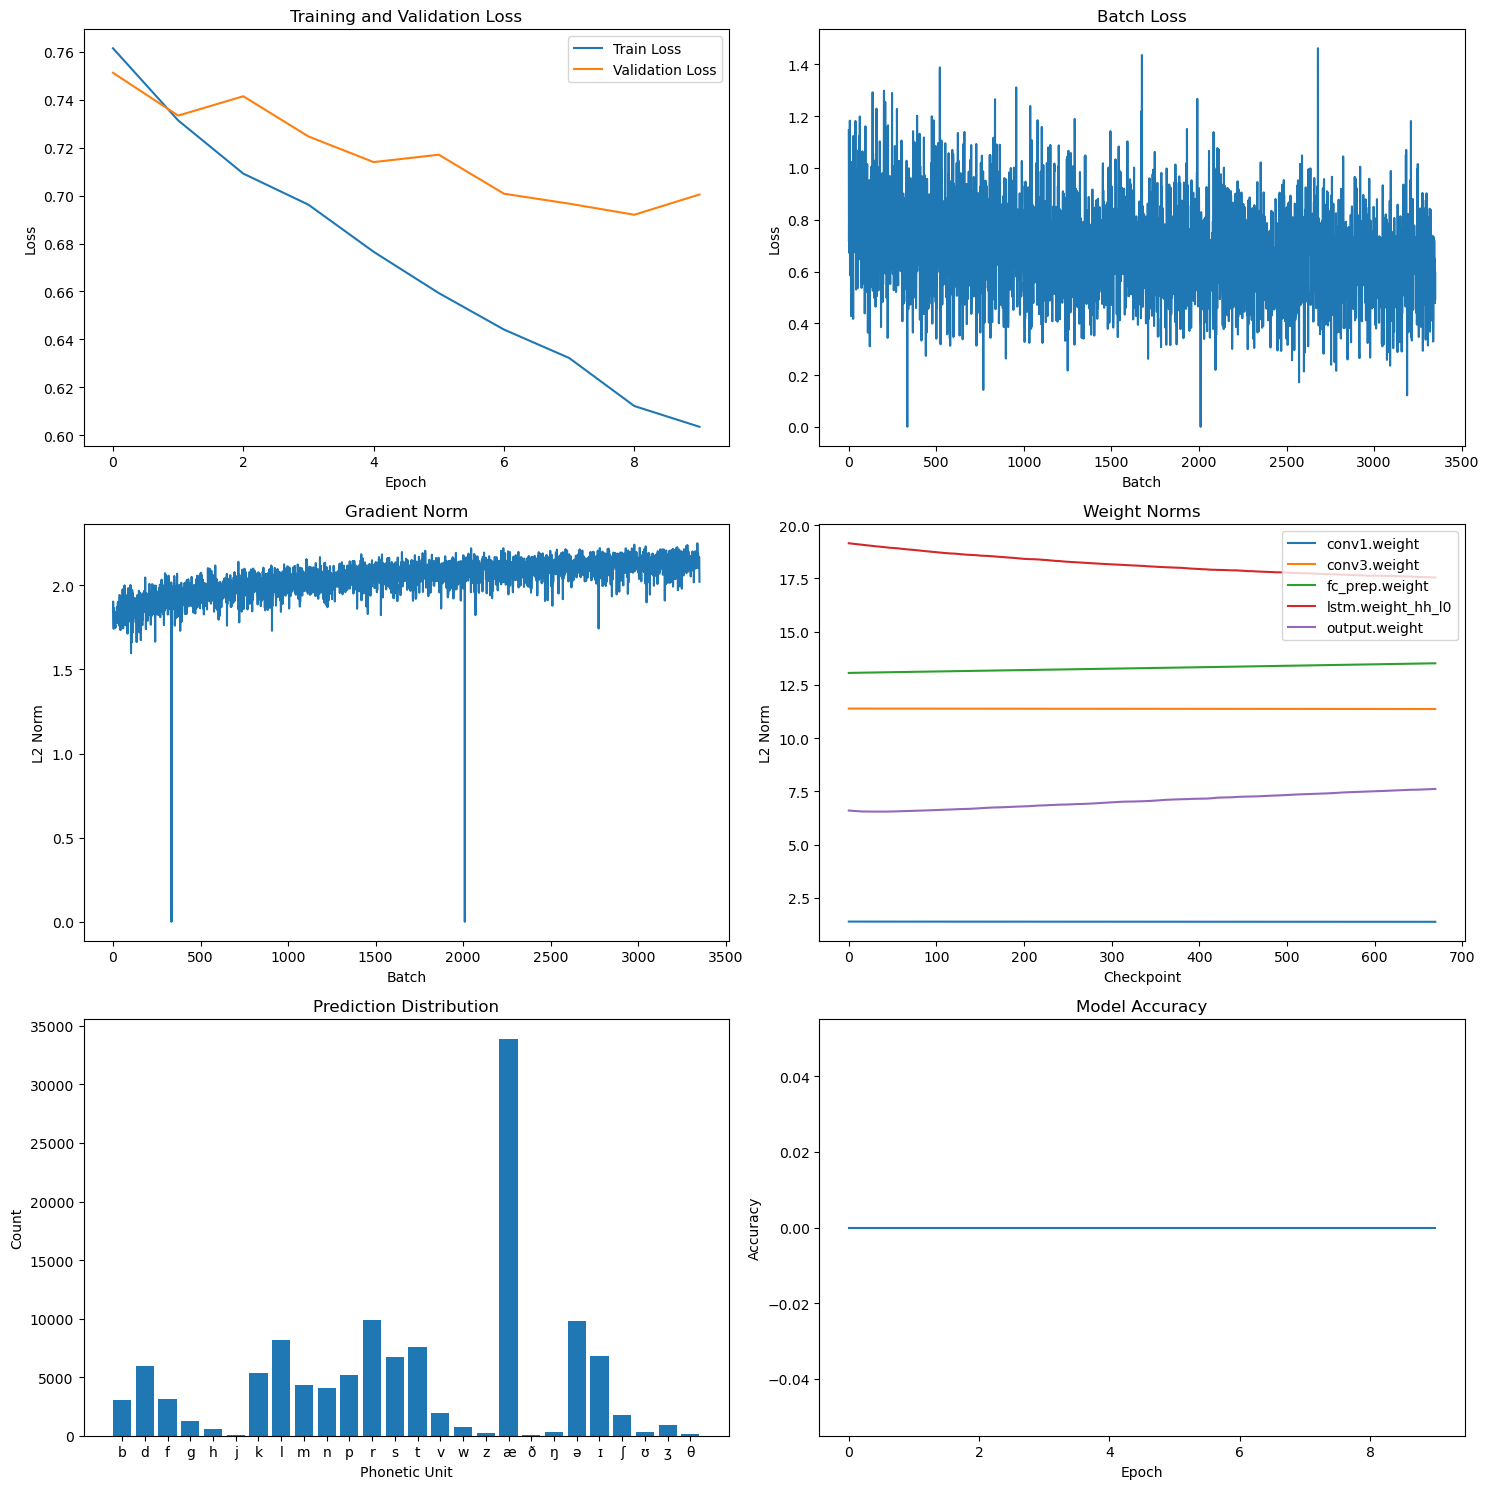

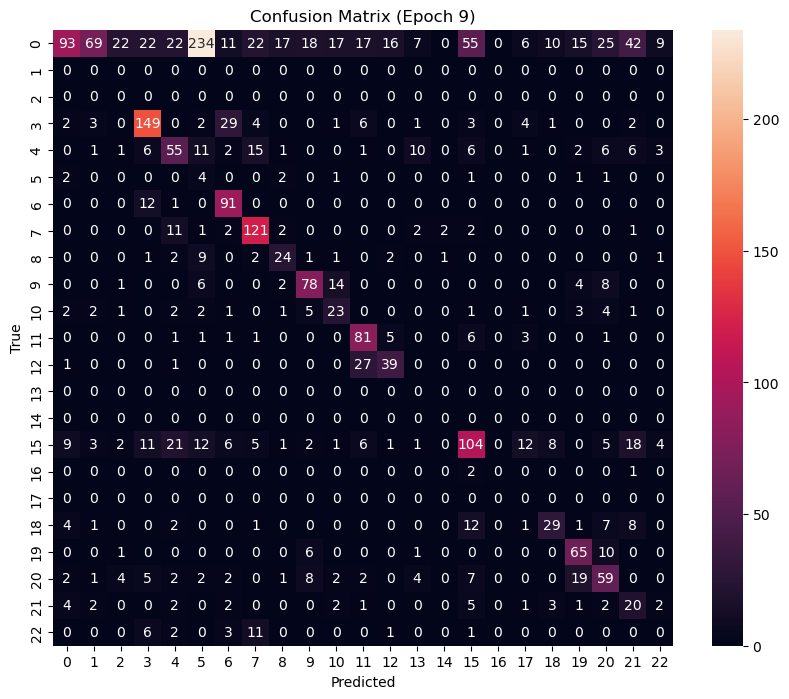

In [214]:
model = monitored_train(model, train_loader, val_loader)



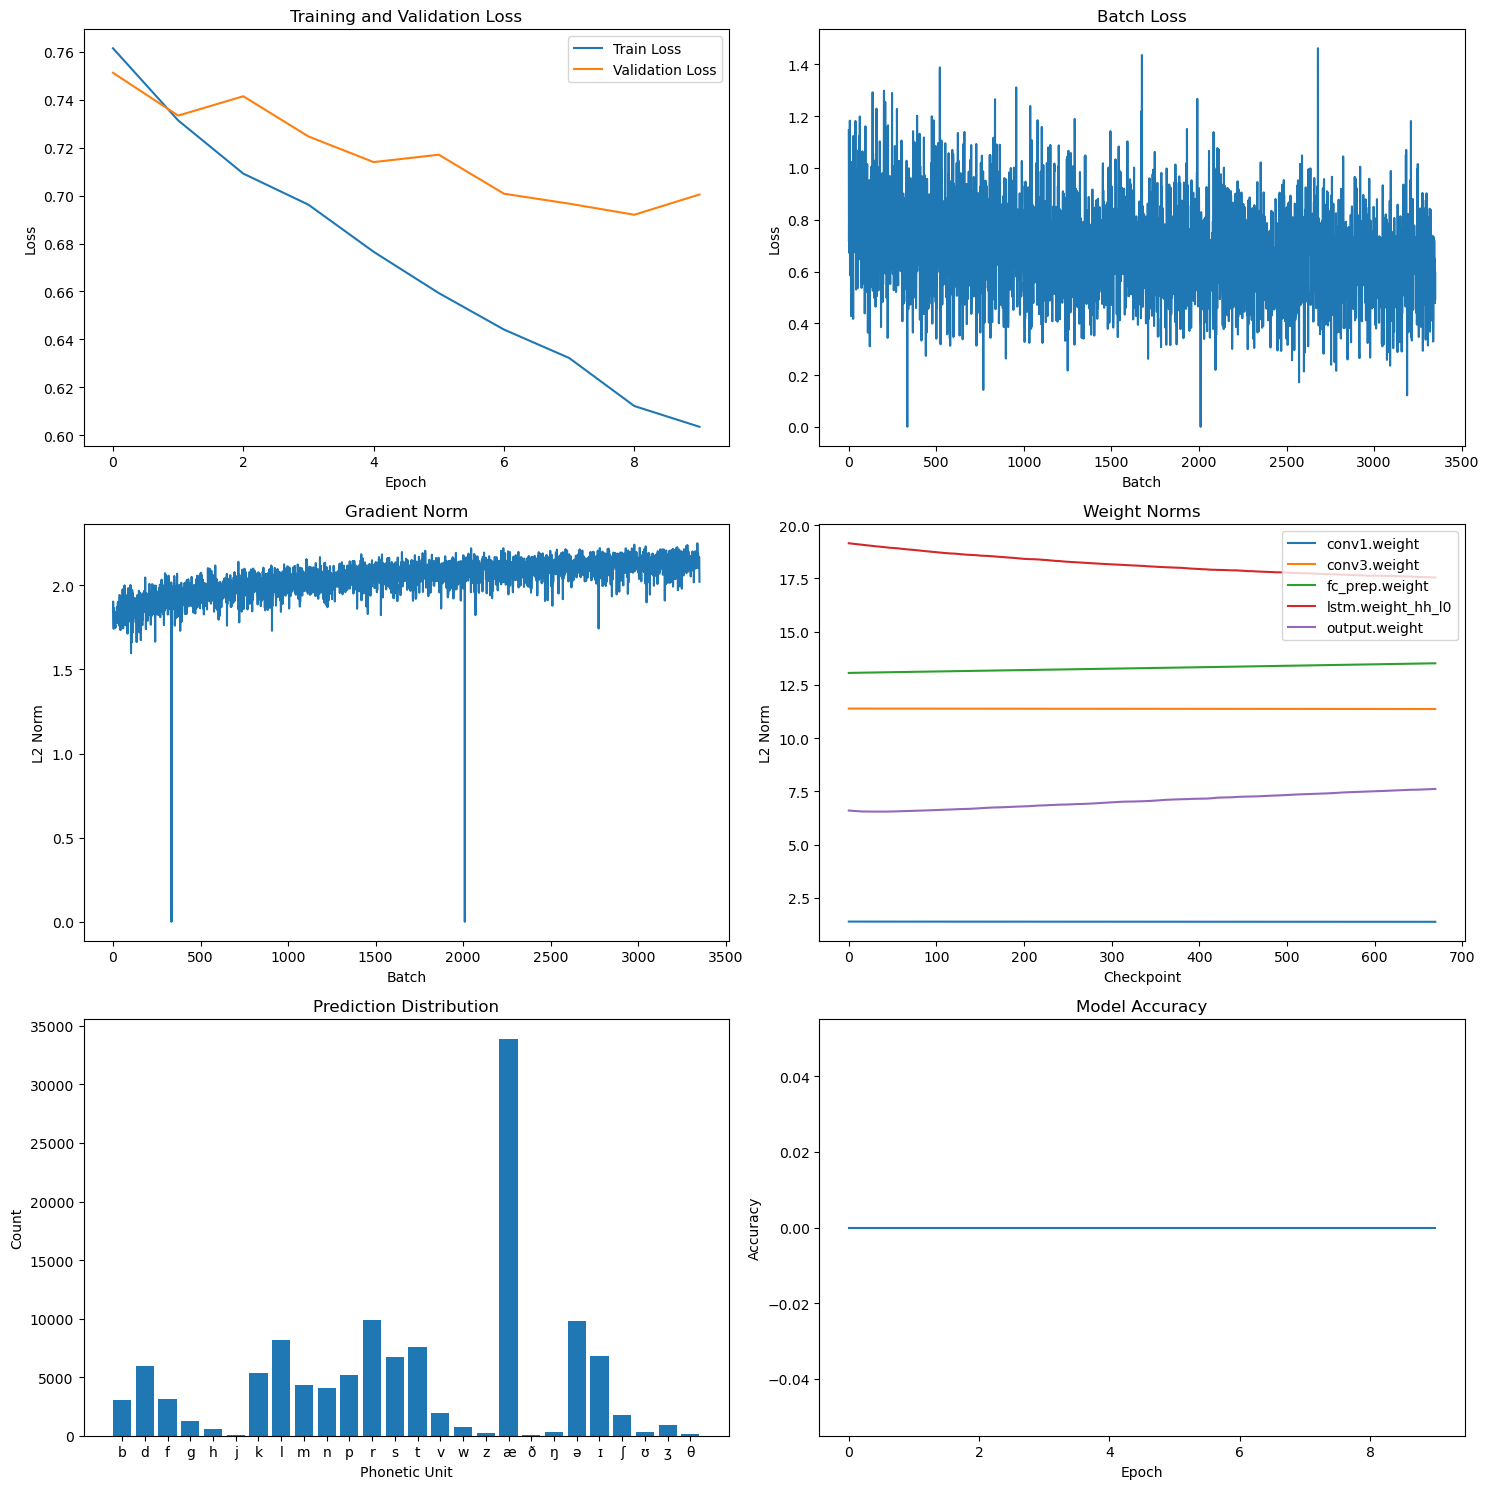

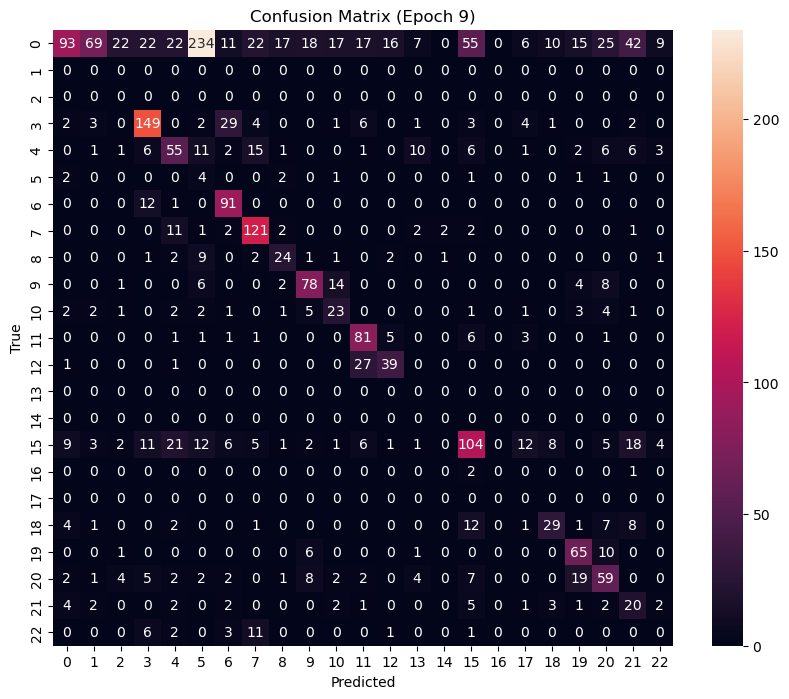

In [215]:
print(monitor.get_diagnostic_report())
monitor.plot_metrics()
